In [1]:
import pandas as pd
import warnings

from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *

path = 'spi_transfers_ver2_ready_for_features.csv'

df = pd.read_csv(path, index_col=0)

warnings.filterwarnings( "ignore", module = "seaborn\..*" )


# Feature Creation

This notebook is dedicated to creating new features for the newly combined `spi` and `transfers` datasets.


### What's happened so far:
 - I started with two datasets, one containing soccer transfers data from nine European leagues over five seasons, and the other containing SPI scores for teams from the same nine leagues over the same five seasons.
 - Both dataframes were cleaned up a bit, but the bulk of the cleaning work was done just before merging the dataframes together. The largest effort in cleaning up the data involved standardizing the team names across the two datasets.
 - I learned something new! I used the FuzzyWuzzy library for the first time, and it is delightful. Using a tutorial, I created a function that matched the team names from each dataframe, and provided the best option for standardizing them for my merged dataframe.


### This notebook will focus on:
 - Feature creation. The dataset I am now working with has massive opportunity for additional features.
 - Next, I'll look at the data more visually, and try to identify some interesting patterns in the data.
 - Finally, I'll work on choosing algorithm(s) for predicting future SPI scores. More on that in another notebook I think...

### STEP ONE: Have a look at the dataset one more time

In [2]:
df.shape

(31080, 14)

This dataframe has 14 columns and 31000+ observations. I will tighten this up a good bit, but I'll still have considerably more datapoints than my previous effort looking at the impact of transfers on soccer team strenght.

In [3]:
%%html
<style>
table {float:left}
</style>

#### Here's a look at the columns that currently exist in this dataset

Column | Definition
----: | :---------
**team_name** | Team name
**player** | Player name
**age** | Age of player
**position** | Player's position
**other_club** | Other team involved in the transfer
**movement** | Whether the player was purchased or sold, e.g. in or out
**window** | There are two transfer windows: summer, winter
**fee_millions** | The fee in millions for the transfer
**league** | Team's home league
**year** | Year associated with each season
**season** | Each season spreads two years, e.g. 2016-2017
**avg_home_spi** | The average SPI score when the team is home
**avg_away_spi** | The average SPI score when the team is away
**avg_spi_score** | The average of home and away SPI scores


In [4]:
# Let's confirm there are no null values
df.isna().sum()

team_name        0
player           0
age              0
position         0
other_club       0
movement         0
window           0
fee_millions     0
league           0
year             0
season           0
avg_home_spi     0
avg_away_spi     0
avg_spi_score    0
dtype: int64

In [5]:
# Renaming team_name to team just to make it easier
df.rename(columns={'team_name': 'team'}, inplace=True)

### Positions: Eleven players on a field

There are 11 players on the pitch for each team, but the positions they fill are not limited to 11 different names. Beyond that, some players play a little bit forward when they are backs (see all of Liverpools backline) and some players play a little bit defensively when they are in the midfield. 

There are a lot of formations in soccer. Here are just a small few:
 - 4-4-2 (a classic)
 - 4-3-3 (think West German dominance)
 - 3-6-1 (US '98 World Cup disaster)
 - 4-5-1
 - 1-1-9 (CHARGE!!!!)

Any way you can combine 11 players, you have a formation for soccer. Below, there are 17 distinct positions in the dataframe, which is too many in my opinion. Look closely at the numbers associated with the position counts, and you'll see that the seven positions with the lowest value counts are significantly lower than the other positions listed.

I'm not going to try to assign a `right` or `left` standard to the positions. Instead, I'll take those bottom seven positions and recategorize them.

In [6]:
positions = df.position.unique()
display(df.position.value_counts())
print(positions.shape)

Centre-Forward        5274
Centre-Back           4860
Central Midfield      3689
Goalkeeper            2972
Left Winger           2368
Defensive Midfield    2296
Left-Back             2283
Right Winger          2265
Right-Back            2073
Attacking Midfield    1966
Second Striker         367
Left Midfield          320
Right Midfield         308
Forward                 20
Midfielder              11
Defender                 5
midfield                 3
Name: position, dtype: int64

(17,)


How I'll rename the positions:
 - I'm going to rename centre-forward, second striker and forward as `striker`. Centre-forward has the highest value count, but I like striker as a more all-encompassing description of an attack-only player.
 - I'm renaming left midfield as `left winger` and right midfield as `right winger`.
 - I'm renaming midfielder and midfield as `central midfield`, and defender as `defensive midfield`. 

In [7]:
new_position = {'Centre-Forward': 'Striker',
                'Second Striker': 'Striker',
                'Left Midfield': 'Left Winger',
                'Right Midfield': 'Right Winger',
                'Forward': 'Striker',
                'Midfielder': 'Central Midfield',
                'Defender': 'Defensive Midfield',
                'midfield': 'Central Midfield'}

df.position.replace(new_position, inplace=True)
df.position.value_counts()

Striker               5661
Centre-Back           4860
Central Midfield      3703
Goalkeeper            2972
Left Winger           2688
Right Winger          2573
Defensive Midfield    2301
Left-Back             2283
Right-Back            2073
Attacking Midfield    1966
Name: position, dtype: int64

### STEP TWO: Build new features for the dataframe

It's time! New features await!

Here's the list of new features that I'll create:

New Feature | Definition
----: | :---------
**total_transfers_in** | Sum of transfers purchased (in) by a team
**total_transfers_out** | Sum of transfers sold (out) by a team
**total_spend** | Sum of the amount spent on purchases (in) by a team
**total_earned** | Sum of the amount earned on sales (out) by a team
**average_fee_spend** | Average fee spent on a purchase (in) by a team
**average_fee_earned** | Average fee earned on a sale (out) by a team
**max_fee_spend** | Max fee spent on a purchase (in) in a season
**min_fee_spend** | Min fee spent on a purchase (in) in a season
**avg_home_spi** | Average home spi score for a team
**avg_away_spi** | Average away spi score for a team
**avg_season_spi** | Average spi score for a team across an entire season
**most_purchased_position** | Position with the most purchases for a team
**position_max_spend** | Position with the highest amount spent (in) by a team
**position_min_spend** | Position with the least amount spent (in) by a team
**avg_spend_striker** | Average spent on a goalkeeper
**avg_spend_centre_back** | Average spent on a goalkeeper
**avg_spend_centre_mid** | Average spent on a goalkeeper
**avg_spend_goalkeeper** | Average spent on a goalkeeper
**avg_spend_left_winger** | Average spent on a goalkeeper
**avg_spend_right_winger** | Average spent on a goalkeeper
**avg_spend_def_midfield** | Average spent on a goalkeeper
**avg_spend_left_back** | Average spent on a goalkeeper
**avg_spend_right_back** | Average spent on a goalkeeper
**avg_spend_att_midfield** | Average spent on a goalkeeper


#### First, I'll define a function to get the most frequent position for a team in a given season


In [8]:
def get_most_frequent(column):
    if len(column) > 0:
        return column.value_counts().index[0]
    else:
        return -1

#### Second, I'll create a function to groupby and aggregate for feature creation

In [9]:
def my_agg(x):
    features = {
        'total_transfers_in': x[x['movement'] == 'in']['fee_millions'].count(),
        'total_transfer_out': x[x['movement'] == 'out']['fee_millions'].count(),
        'total_spend': x[x['movement'] == 'in']['fee_millions'].sum(),
        'total_earned': x[x['movement'] == 'out']['fee_millions'].sum(),
        'average_fee_spend': x[x['movement'] == 'in']['fee_millions'].mean(),
        'average_fee_earned': x[x['movement'] == 'out']['fee_millions'].mean(),
        'max_fee_spend': x[x['movement'] == 'in']['fee_millions'].max(),
        'min_fee_spend': x[x['movement'] == 'out']['fee_millions'].max(),
        'avg_home_spi': x['avg_home_spi'].mean(),
        'avg_away_spi': x['avg_away_spi'].mean(),
        'avg_season_spi': x['avg_spi_score'].mean(),
        'most_purchased_position': get_most_frequent(x[x['movement'] == 'in']['position']),
        'position_max_spend': x.sort_values(by='fee_millions', ascending=False)['position'].iloc[0],
        'position_min_spend': x.sort_values(by='fee_millions', ascending=True)['position'].iloc[0],
        'avg_spend_striker': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Striker')]['fee_millions'].mean(),
        'avg_spend_centre_back': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Centre-Back')]['fee_millions'].mean(),
        'avg_spend_centre_mid': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Central Midfield')]['fee_millions'].mean(),
        'avg_spend_goalkeeper': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Goalkeeper')]['fee_millions'].mean(),
        'avg_spend_left_winger': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Left Winger')]['fee_millions'].mean(),
        'avg_spend_right_winger': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Right Winger')]['fee_millions'].mean(),
        'avg_spend_def_midfield': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Defensive Midfield')]['fee_millions'].mean(),
        'avg_spend_left_back': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Left-Back')]['fee_millions'].mean(),
        'avg_spend_right_back': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Right-Back')]['fee_millions'].mean(),
        'avg_spend_att_midfield': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Attacking Midfield')]['fee_millions'].mean()
    }
    
    return pd.Series(features)

#### Third, I apply the aggregation to `df` grouped by `year`, `team` and `league`. 


In [10]:
df = df.groupby(['year', 'team', 'league'], as_index=False).apply(my_agg)
df.sort_values(by=['team', 'year'], inplace=True)
df.sort_index(inplace=True)

In [11]:
# A quick look at the new df
df.head()

year             team                  league  total_transfers_in  \
0  2016   1.FSV Mainz 05       German Bundesliga                  16   
1  2016         AC Milan         Italian Serie A                  12   
2  2016   ACF Fiorentina         Italian Serie A                  16   
3  2016  AFC Bournemouth  English Premier League                  20   
4  2016        AS Monaco          French Ligue 1                  24   

   total_transfer_out  total_spend  total_earned  average_fee_spend  \
0                  16       26.284        23.135           1.642750   
1                  29       26.600        22.640           2.216667   
2                  43       14.157        27.950           0.884813   
3                  29       36.626        21.321           1.831300   
4                  29       45.450        16.605           1.893750   

   average_fee_earned  max_fee_spend  ...  avg_spend_striker  \
0            1.445938           5.85  ...             2.0250   
1            0.780690           8.60  ...             4.2750   
2            0.650000           3.15  ...                NaN   
3            0.735207          16.20  ...             1.4625   
4            0.572586          13.50  ...             0.0000   

   avg_spend_centre_back  avg_spend_centre_mid  avg_spend_goalkeeper  \
0                 0.4500                 1.930                 2.250   
1                 8.6000                 3.825                 0.000   
2                 1.3500                 0.450                 0.849   
3                 0.5175                 1.684                 0.846   
4                 3.3000                 2.700                 0.000   

  avg_spend_left_winger avg_spend_right_winger avg_spend_def_midfield  \
0                 1.350                   2.10                   2.25   
1                 0.630                   0.45                    NaN   
2                 0.225                   0.00                   0.00   
3                   NaN                   4.05                    NaN   
4                 0.000                   0.00                   0.00   

   avg_spend_left_back  avg_spend_right_back  avg_spend_att_midfield  
0                0.054                   NaN                   0.000  
1                0.000                   NaN                   0.720  
2                0.450                  2.61                   1.575  
3                1.620                   NaN                     NaN  
4                6.450                 13.50                   0.000  

[5 rows x 27 columns]

##### `avg_home_spi` and `avg_away_spi` need to be dropped, because they helped created `avg_season_spi`

In [12]:
df.drop(columns=['avg_home_spi', 'avg_away_spi'], inplace=True)

In [13]:
display(df.shape)
df.isna().sum()

(762, 25)

year                         0
team                         0
league                       0
total_transfers_in           0
total_transfer_out           0
total_spend                  0
total_earned                 0
average_fee_spend            0
average_fee_earned           0
max_fee_spend                0
min_fee_spend                0
avg_season_spi               0
most_purchased_position      0
position_max_spend           0
position_min_spend           0
avg_spend_striker           22
avg_spend_centre_back       39
avg_spend_centre_mid        96
avg_spend_goalkeeper       118
avg_spend_left_winger      149
avg_spend_right_winger     156
avg_spend_def_midfield     187
avg_spend_left_back        170
avg_spend_right_back       186
avg_spend_att_midfield     220
dtype: int64

#### WOW!

If I'm honest, I find that process pretty fun. It took some Google searching to find the right aggs for my features, but I'm better for it and I'm really excited to crack on with the next steps.

What just happend:
 - I created a heap of new features to get better info around which positions matter to teams, and then I grouped the dataframe by year and team. This cut my datapoints down to 700+ from 31000+, but I now have a datapoint for each team, for each season, and a whole lot of other fun data alongside that wasn't 'visible' before.

First, I'll fill the new null values with zeroes. If they are missing, it's because the position didn't exist in a team's purchases that season.

In [14]:
df.fillna(0,inplace=True)
df.dtypes

year                         int64
team                        object
league                      object
total_transfers_in           int64
total_transfer_out           int64
total_spend                float64
total_earned               float64
average_fee_spend          float64
average_fee_earned         float64
max_fee_spend              float64
min_fee_spend              float64
avg_season_spi             float64
most_purchased_position     object
position_max_spend          object
position_min_spend          object
avg_spend_striker          float64
avg_spend_centre_back      float64
avg_spend_centre_mid       float64
avg_spend_goalkeeper       float64
avg_spend_left_winger      float64
avg_spend_right_winger     float64
avg_spend_def_midfield     float64
avg_spend_left_back        float64
avg_spend_right_back       float64
avg_spend_att_midfield     float64
dtype: object

### STEP THREE: Visualize that data!

To have a look at patterns in the new dataframe, I'm going to use the `QuickDA` library. I've never used it before, so I'll give it my best shot and crack on from there.

QuickDA has a number of functions and parameters that are supposed to make EDA a faster, easier, less painful process. I'm going to give it a bash, and if I need to use other visualizations to find patterns, I will.

#### First, the `explore` method summarizes the dataset like `.describe()`, but includes columns of any data type.

In [15]:
explore(df, method='summarize')

dtypes  count  null_sum  null_pct  nunique  \
average_fee_earned       float64    762         0       0.0      654   
average_fee_spend        float64    762         0       0.0      674   
avg_season_spi           float64    762         0       0.0      749   
avg_spend_att_midfield   float64    762         0       0.0      111   
avg_spend_centre_back    float64    762         0       0.0      263   
avg_spend_centre_mid     float64    762         0       0.0      230   
avg_spend_def_midfield   float64    762         0       0.0      134   
avg_spend_goalkeeper     float64    762         0       0.0      114   
avg_spend_left_back      float64    762         0       0.0      135   
avg_spend_left_winger    float64    762         0       0.0      161   
avg_spend_right_back     float64    762         0       0.0      128   
avg_spend_right_winger   float64    762         0       0.0      153   
avg_spend_striker        float64    762         0       0.0      307   
league                    object    762         0       0.0        9   
max_fee_spend            float64    762         0       0.0      236   
min_fee_spend            float64    762         0       0.0      252   
most_purchased_position   object    762         0       0.0       10   
position_max_spend        object    762         0       0.0       10   
position_min_spend        object    762         0       0.0       10   
team                      object    762         0       0.0      218   
total_earned             float64    762         0       0.0      573   
total_spend              float64    762         0       0.0      598   
total_transfer_out         int64    762         0       0.0       56   
total_transfers_in         int64    762         0       0.0       39   
year                       int64    762         0       0.0        5   

                                        min       25%       50%       75%  \
average_fee_earned                      0.0  0.131575  0.646986  1.726435   
average_fee_spend                       0.0  0.150381      0.78  2.558706   
avg_season_spi                        24.42     48.61     60.58    70.875   
avg_spend_att_midfield                  0.0       0.0       0.0       0.0   
avg_spend_centre_back                   0.0       0.0  0.186083     1.575   
avg_spend_centre_mid                    0.0       0.0       0.0      1.35   
avg_spend_def_midfield                  0.0       0.0       0.0  0.357187   
avg_spend_goalkeeper                    0.0       0.0       0.0    0.1125   
avg_spend_left_back                     0.0       0.0       0.0  0.264375   
avg_spend_left_winger                   0.0       0.0       0.0       0.9   
avg_spend_right_back                    0.0       0.0       0.0      0.27   
avg_spend_right_winger                  0.0       0.0       0.0       0.9   
avg_spend_striker                       0.0       0.0    0.3825      2.34   
league                     Dutch Eredivisie         -         -         -   
max_fee_spend                           0.0      1.53     5.605   15.2775   
min_fee_spend                           0.0       1.8       7.2   19.1475   
most_purchased_position  Attacking Midfield         -         -         -   
position_max_spend       Attacking Midfield         -         -         -   
position_min_spend       Attacking Midfield         -         -         -   
team                         1.FC Nuremberg         -         -         -   
total_earned                            0.0    2.3445    13.455  37.19525   
total_spend                             0.0   2.74875   13.4715    43.335   
total_transfer_out                        4      15.0      20.0      25.0   
total_transfers_in                        3      14.0      18.0      23.0   
year                                   2016    2017.0    2018.0    2019.0   

                                          max         mean    median  \
average_fee_earned                    17.4375     1.375258  0.646986   
averag

#### Second, QuickDA has a `clean()` function that can remove duplicates, null values, change data types, etc.

In [16]:
df = clean(df, method='duplicates')

In [17]:
to_categoric = ['most_purchased_position', 'position_max_spend', 'position_min_spend']
df = clean(df, method='dtypes', columns=to_categoric, dtype='category')

#### Third, QuickDA has a `eda_num()` function that visualizes creates a boxplot and a distribution plot of each numerical feature.

Outlier Analysis - Boxplot


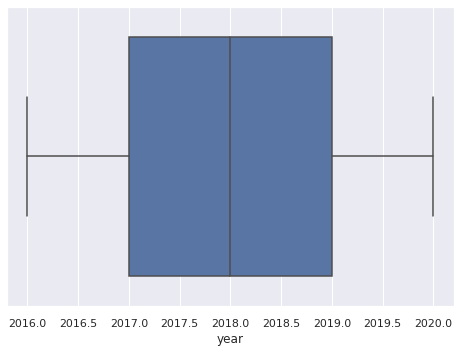

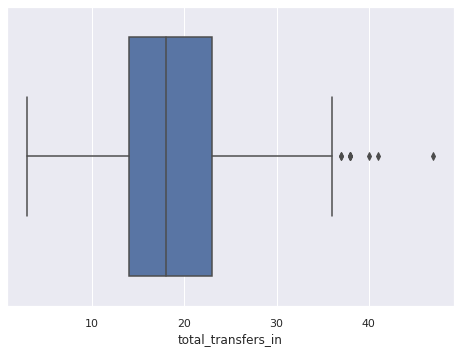

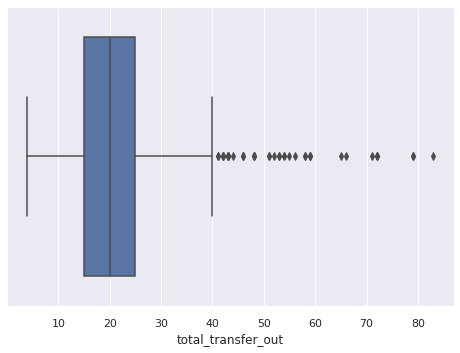

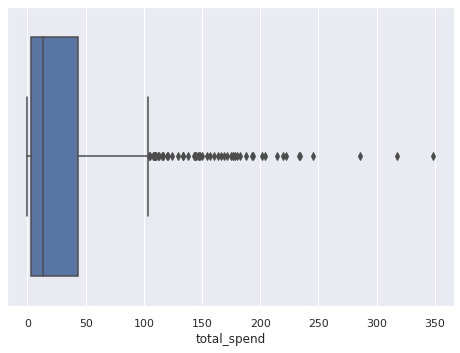

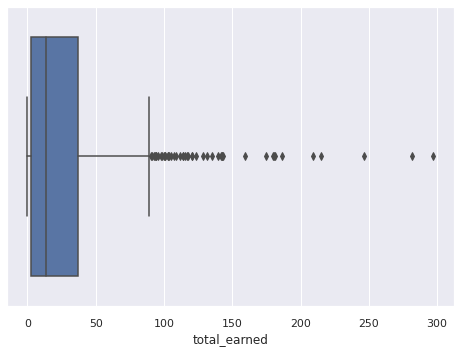

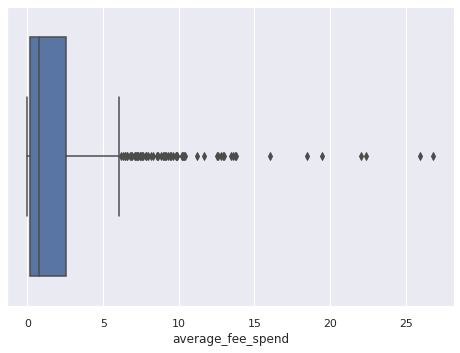

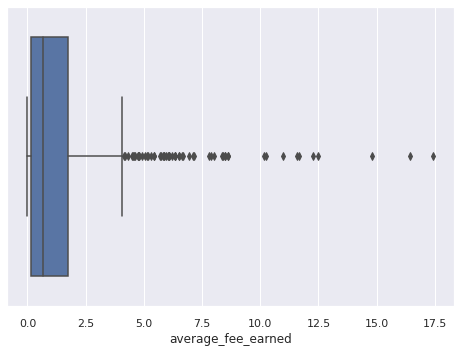

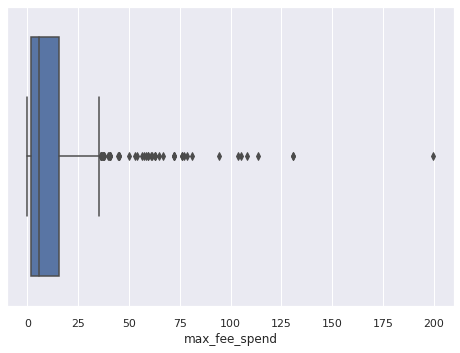

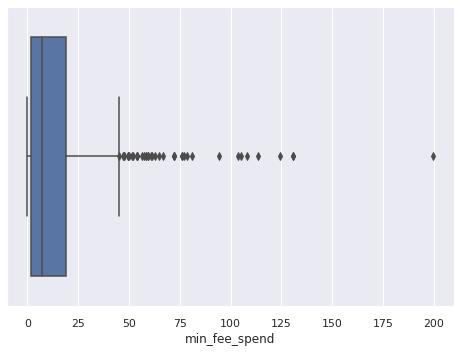

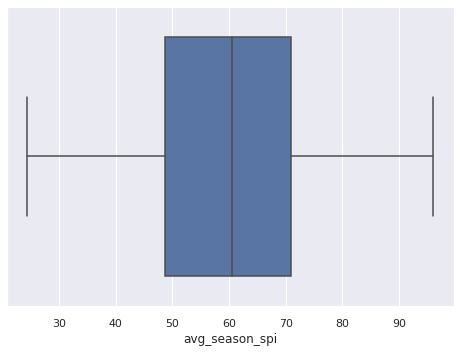

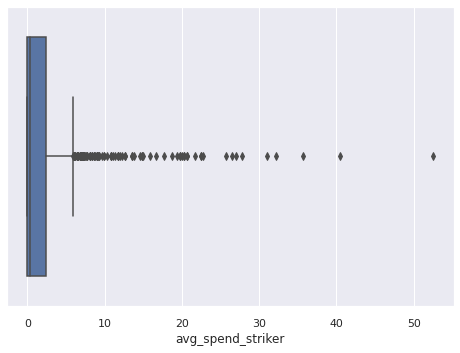

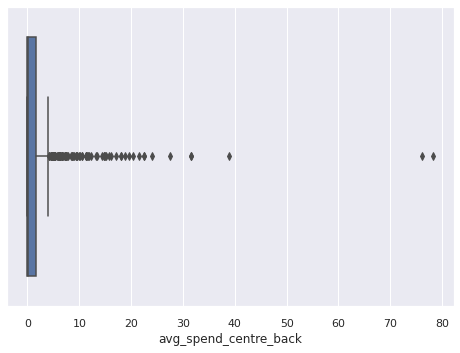

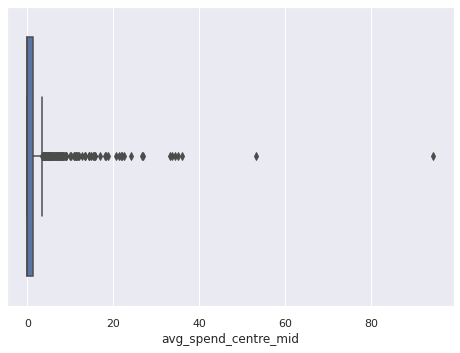

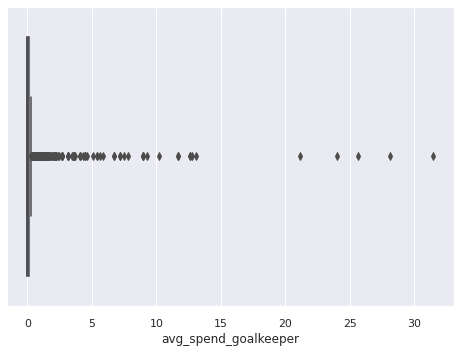

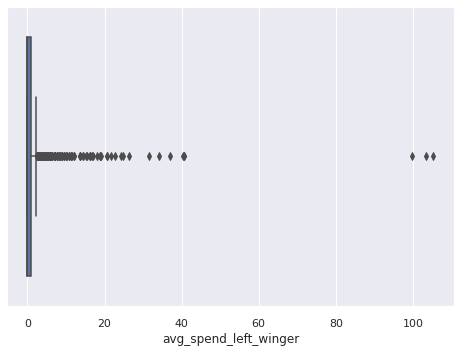

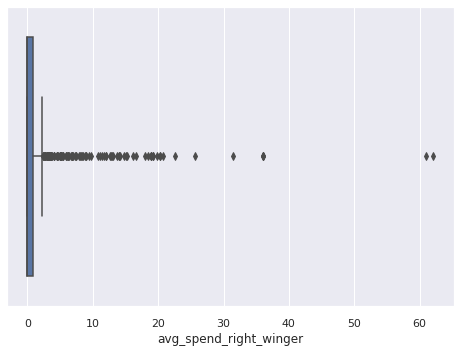

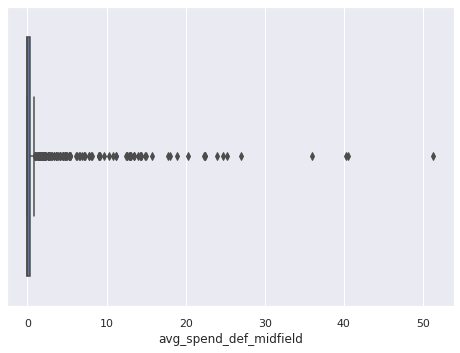

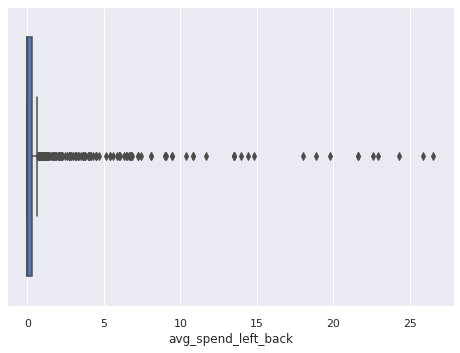

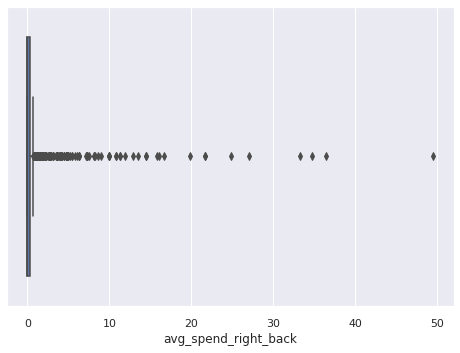

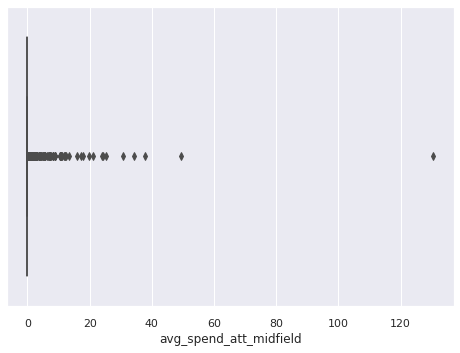

Distribution Analysis - Histogram


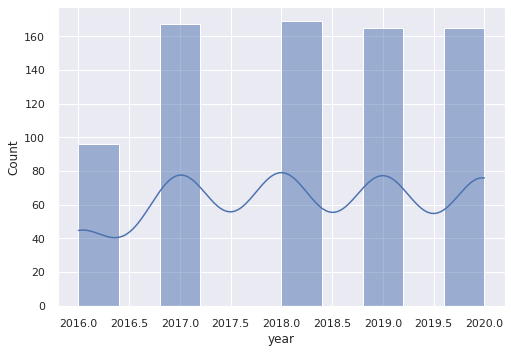

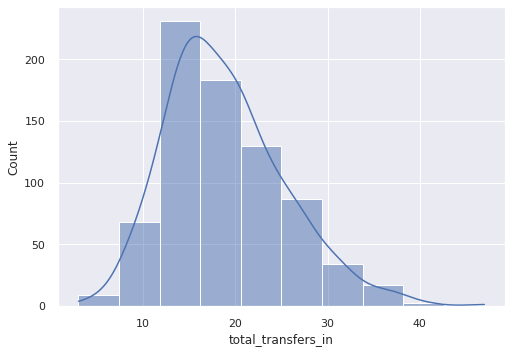

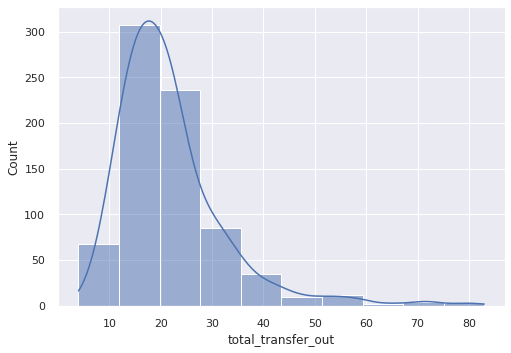

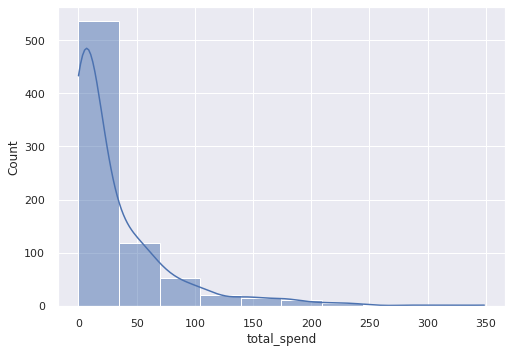

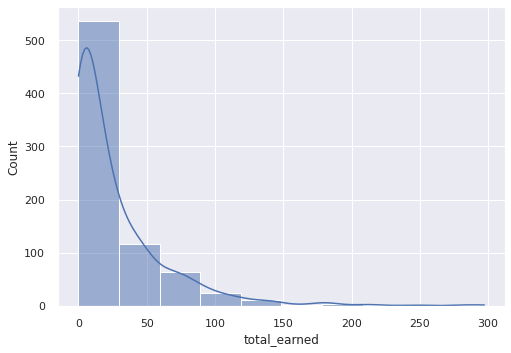

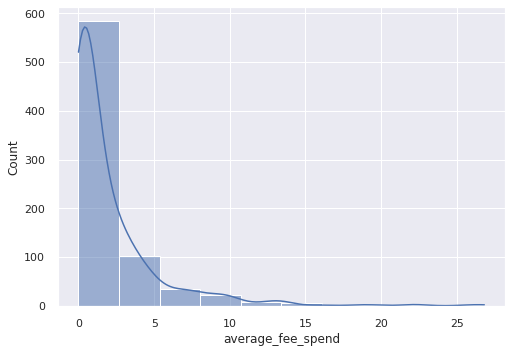

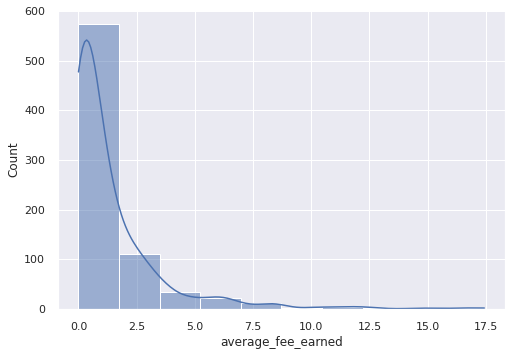

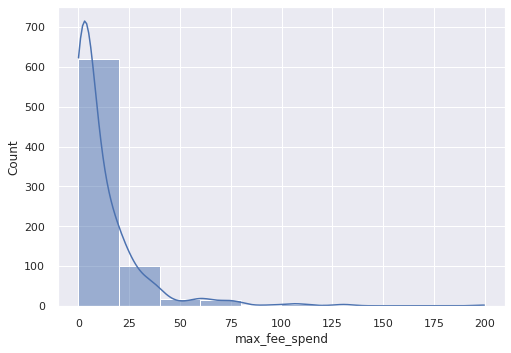

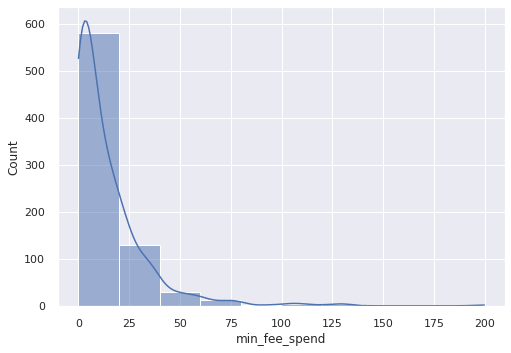

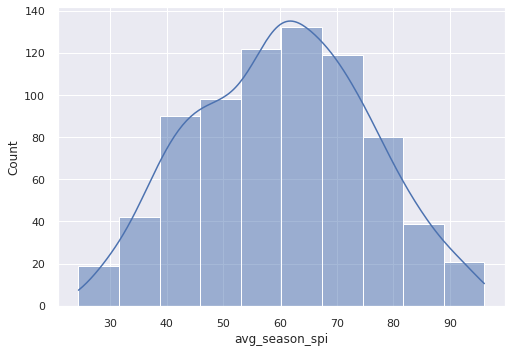

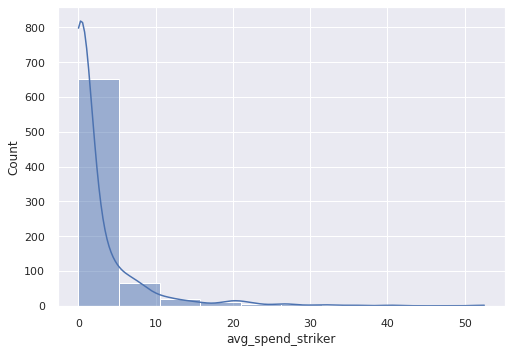

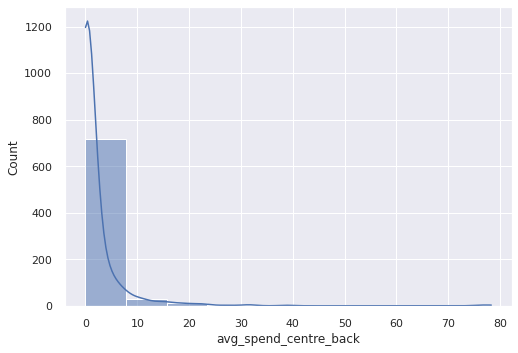

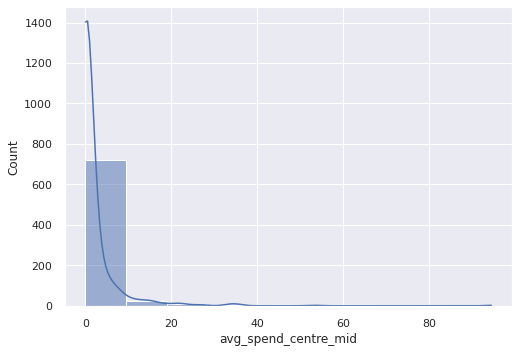

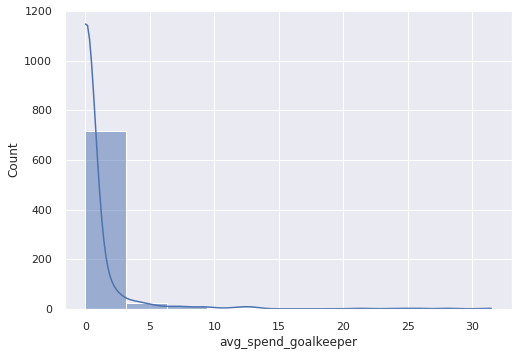

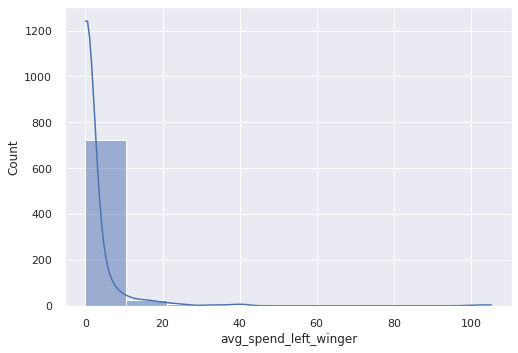

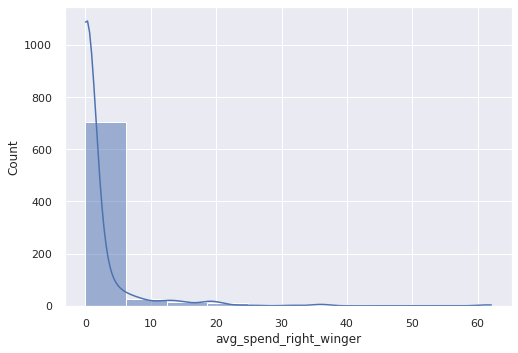

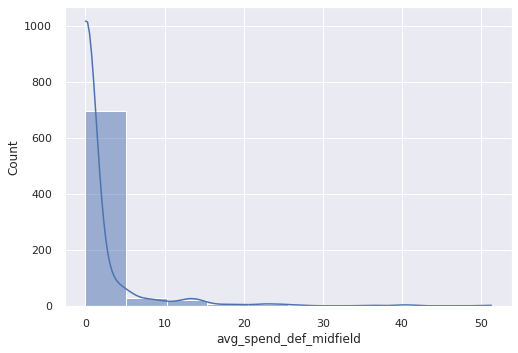

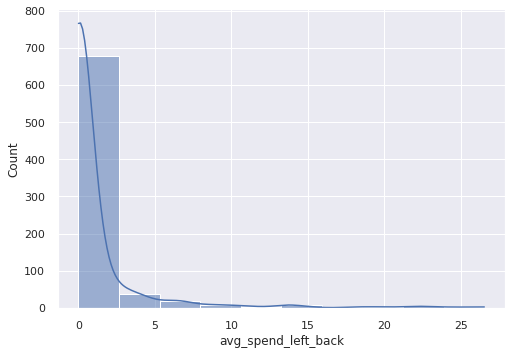

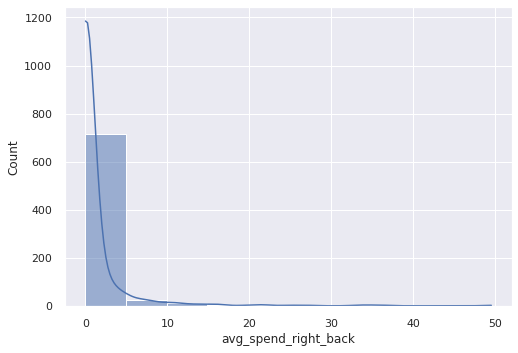

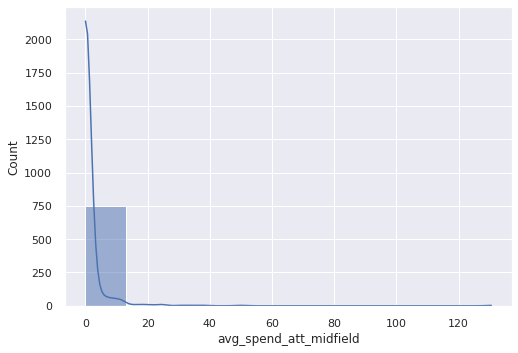

In [18]:
eda_num(df, method='default', bins=10)

#### Fourth, QuickDA has a function `eda_cat()` that creates a barplot and a summary of each categorical feature.

Bar Plot of most_purchased_position


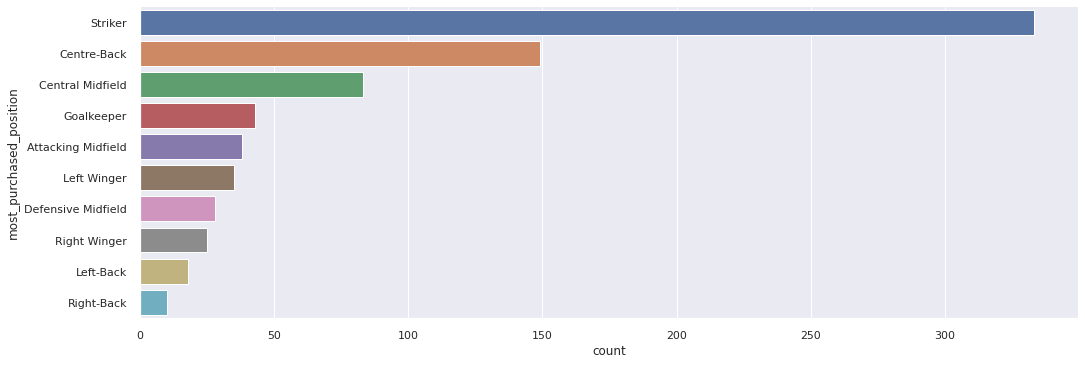

Summary of most_purchased_position


count  relative_pct
Striker               333          0.44
Centre-Back           149          0.20
Central Midfield       83          0.11
Goalkeeper             43          0.06
Attacking Midfield     38          0.05
Left Winger            35          0.05
Defensive Midfield     28          0.04
Right Winger           25          0.03
Left-Back              18          0.02
Right-Back             10          0.01

In [19]:
eda_cat(df, 'most_purchased_position')

Bar Plot of position_max_spend


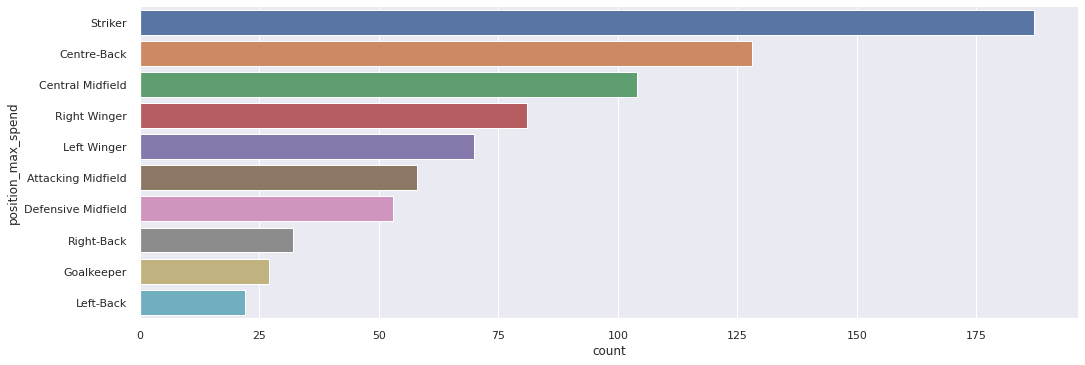

Summary of position_max_spend


count  relative_pct
Striker               187          0.25
Centre-Back           128          0.17
Central Midfield      104          0.14
Right Winger           81          0.11
Left Winger            70          0.09
Attacking Midfield     58          0.08
Defensive Midfield     53          0.07
Right-Back             32          0.04
Goalkeeper             27          0.04
Left-Back              22          0.03

In [20]:
eda_cat(df, 'position_max_spend')

Bar Plot of position_min_spend


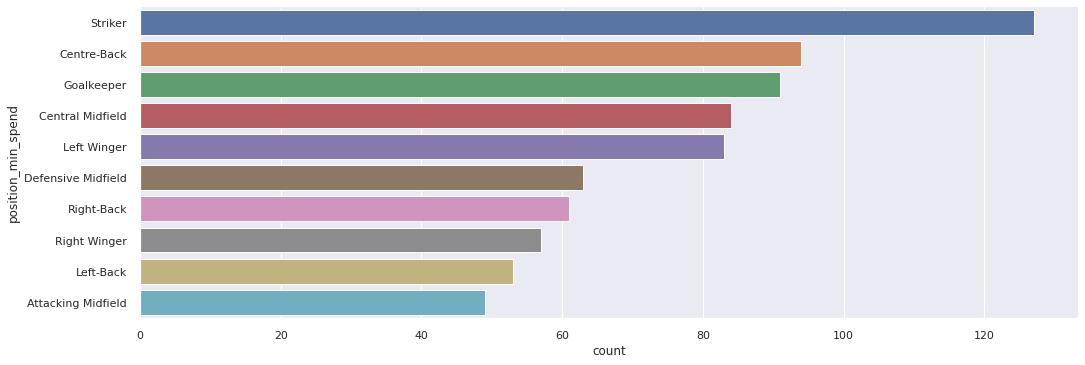

Summary of position_min_spend


count  relative_pct
Striker               127          0.17
Centre-Back            94          0.12
Goalkeeper             91          0.12
Central Midfield       84          0.11
Left Winger            83          0.11
Defensive Midfield     63          0.08
Right-Back             61          0.08
Right Winger           57          0.07
Left-Back              53          0.07
Attacking Midfield     49          0.06

In [21]:
eda_cat(df, 'position_min_spend')

In [22]:
# Creating a list of the numerical and categorical features
numerical = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical = df.select_dtypes(include=['category']).columns.tolist()

### QuickDA Review and Next Steps:

QuickDA uses a few functions with a variety of parameter options to create visualizations and summaries of a dataframe's features. It's a good library, and it has a wider range of chart features that I didn't utilize here.

However, I think coming up with your own methods for visualizing data and creating functions to help you in this step are as useful as QuickDA. In the future, I think I'd use QuickDA to be...quick. And use my own functions or methods to be more deliberate in my analysis.

And to that point - I'll continue with my own functions and methods.

In [23]:
def plot_categorical(df, var_name, target_name, width=7, height=5):
    '''
    Takes a categorical variable and provides a summary 
    and a visualization of that variable as it relates 
    to the target variable.
    
    df = dataframe
    var_name = categorical feature
    target_name = target feature
    '''
    ratio_population = round(df.loc[:, target_name].mean(), 1)
    target_proportion = round(df.loc[:, [target_name, var_name]].groupby([var_name]).mean(), 1)
    print(target_proportion)
    
    categorical_distribution = df.loc[:, [target_name, var_name]].groupby([var_name]).count()
    
    fig = plt.figure(figsize=(width, height))
    fig.autofmt_xdate(rotation=45)
    ax = categorical_distribution[target_name].plot(kind='bar')
    ax.set_ylabel('Number of Samples', color='black')
    ax2 = ax.twinx()
    ax2.grid(False)
    ax2.plot(target_proportion[target_name].values, color='darkorange', linestyle='-', 
             alpha=0.9, marker='.', markeredgewidth=2, linewidth=3.0)
    ax2.set_ylabel('Average Season SPI')
    plt.title('Description of Variable: {0}\n Average Season SPI: {1}'.format(
        var_name, ratio_population));
    
def plot_continuous(df, var_name, target_name, width=7, height=5, bins='auto'):
    '''
    Takes a continuous variable and provides a summary 
    and a visualization of that variable as it relates 
    to the target variable.
    
    df = dataframe
    var_name = continuous feature
    target_name = target feature
    '''
    plot_categorical(df, var_name, target_name, width=7, height=5);

                         avg_season_spi
most_purchased_position                
Attacking Midfield                 62.9
Central Midfield                   61.4
Centre-Back                        62.0
Defensive Midfield                 57.9
Goalkeeper                         61.0
Left Winger                        57.7
Left-Back                          65.3
Right Winger                       63.7
Right-Back                         65.2
Striker                            58.8
                    avg_season_spi
position_max_spend                
Attacking Midfield            58.2
Central Midfield              62.1
Centre-Back                   61.1
Defensive Midfield            61.2
Goalkeeper                    55.3
Left Winger                   63.8
Left-Back                     56.2
Right Winger                  60.3
Right-Back                    59.1
Striker                       59.5
                    avg_season_spi
position_min_spend                
Attacking Midfield            

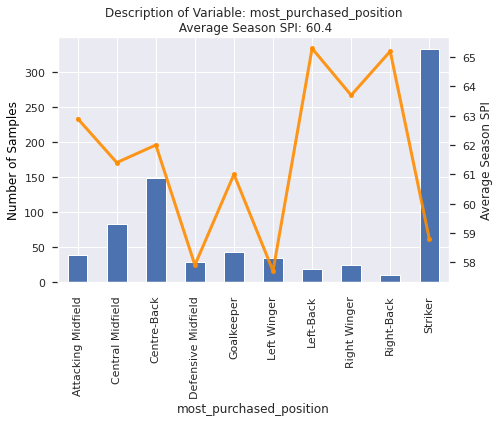

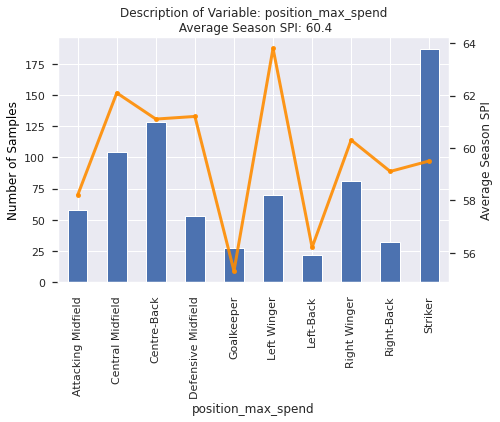

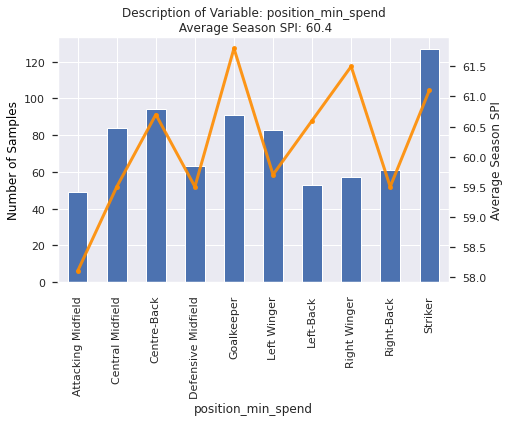

In [24]:
for var in categorical:
    plot_categorical(df, var, 'avg_season_spi')

#### I like to create violin plots to help me understand distributions more clearly. QuickDA does this, but they aren't hard to do quickly on your own if you're keen.

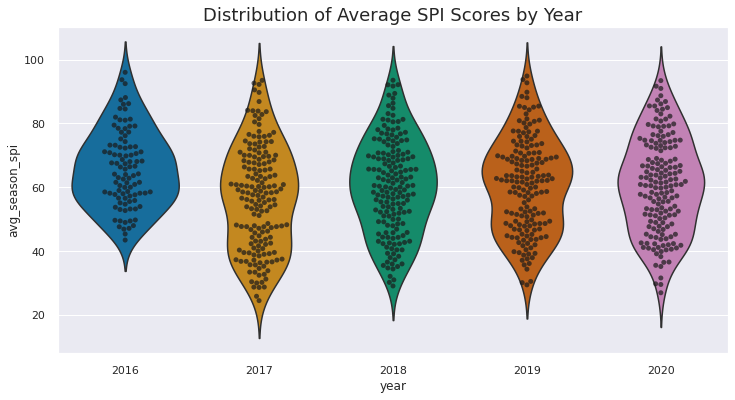

In [25]:
plt.figure(figsize=(12,6))
sns.violinplot(x='year',
              y='avg_season_spi',
              data=df,
              inner=None,
              palette= 'colorblind')

sns.swarmplot(x='year',
              y='avg_season_spi',
              data=df,
              color='k',
              alpha=0.7)

plt.title('Distribution of Average SPI Scores by Year', fontsize=18);

#### A quick look at the ten best and ten worst teams in terms of `avg_season_spi`

In [26]:
display(df.sort_values(by='avg_season_spi', ascending=False)[['team', 'avg_season_spi']].head(10))
display(df.sort_values(by='avg_season_spi')[['team', 'avg_season_spi']].head(10))

team  avg_season_spi
32      FC Barcelona           96.04
525  Manchester City           94.88
452    Bayern Munich           93.77
13     Bayern Munich           93.72
358  Manchester City           93.56
154     FC Barcelona           93.52
688  Manchester City           93.44
522     Liverpool FC           92.75
117    Bayern Munich           92.64
64       Real Madrid           92.49

team  avg_season_spi
218  Roda JC Kerkrade           24.42
130     Burton Albion           25.79
601      ADO Den Haag           26.89
123  Bolton Wanderers           28.56
197         NAC Breda           28.67
249         VVV-Venlo           28.68
364         NAC Breda           29.02
547      RKC Waalwijk           29.37
709      RKC Waalwijk           29.49
748         VVV-Venlo           29.69

#### This isn't the prettiest boxplot ever, but it does a good job showing the range of `avg_season_spi` scores by season for each club in the dataset.

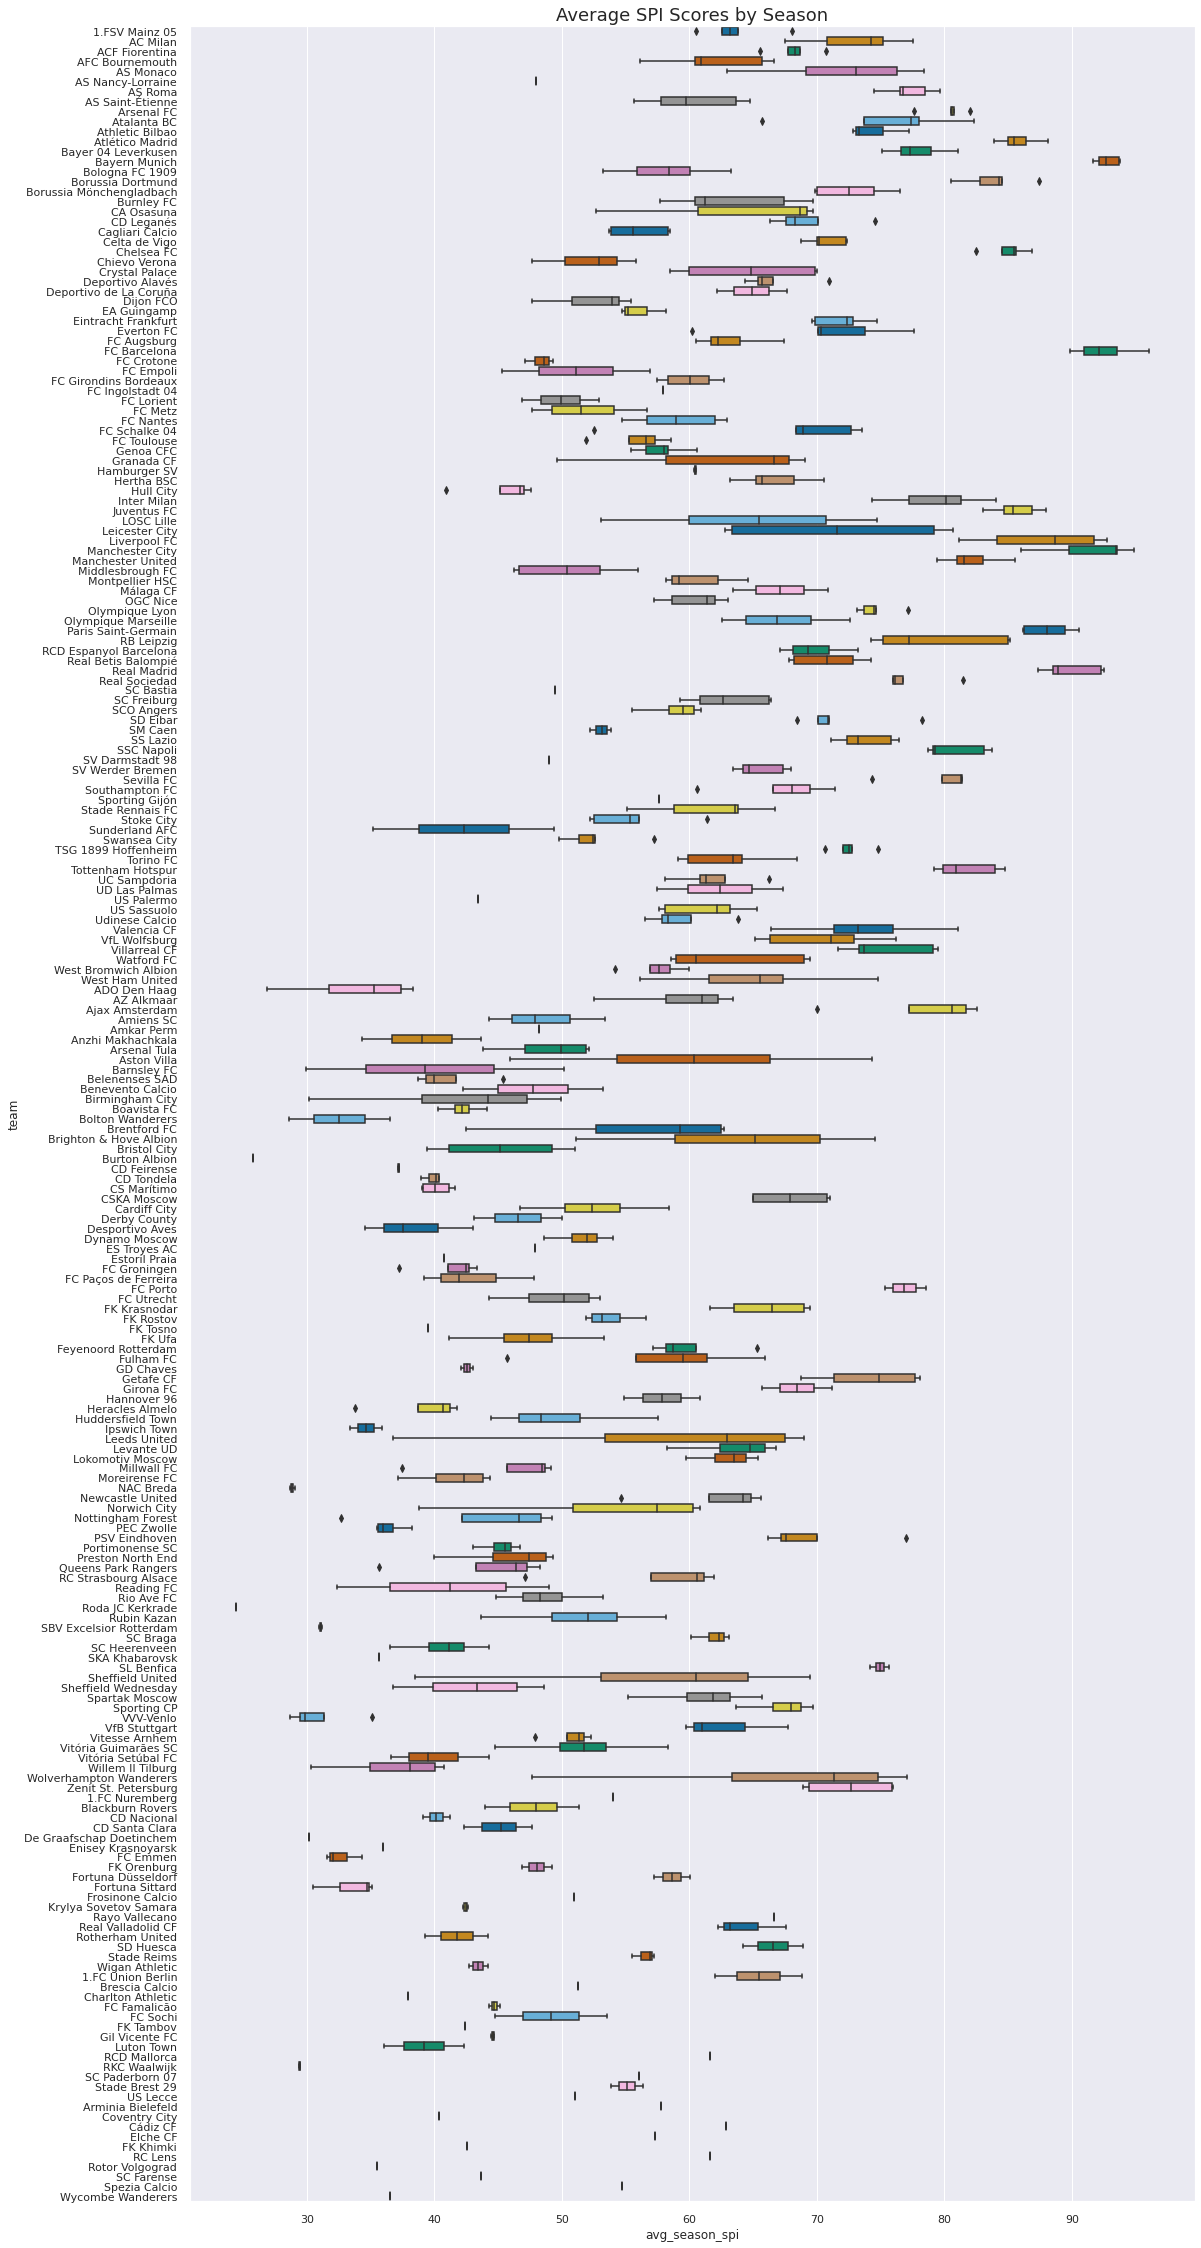

In [27]:
plt.figure(figsize=(18,40))
sns.boxplot(x='avg_season_spi', y='team', data=df, palette='colorblind')
plt.title('Average SPI Scores by Season', fontsize=18);

#### Again, not the prettiest, but another boxplot that shows the `average_fee_spend` by team by season.

Have a look at Inter Milan's spread, and at how much of the dataset tend to spend basically the same amount each season.

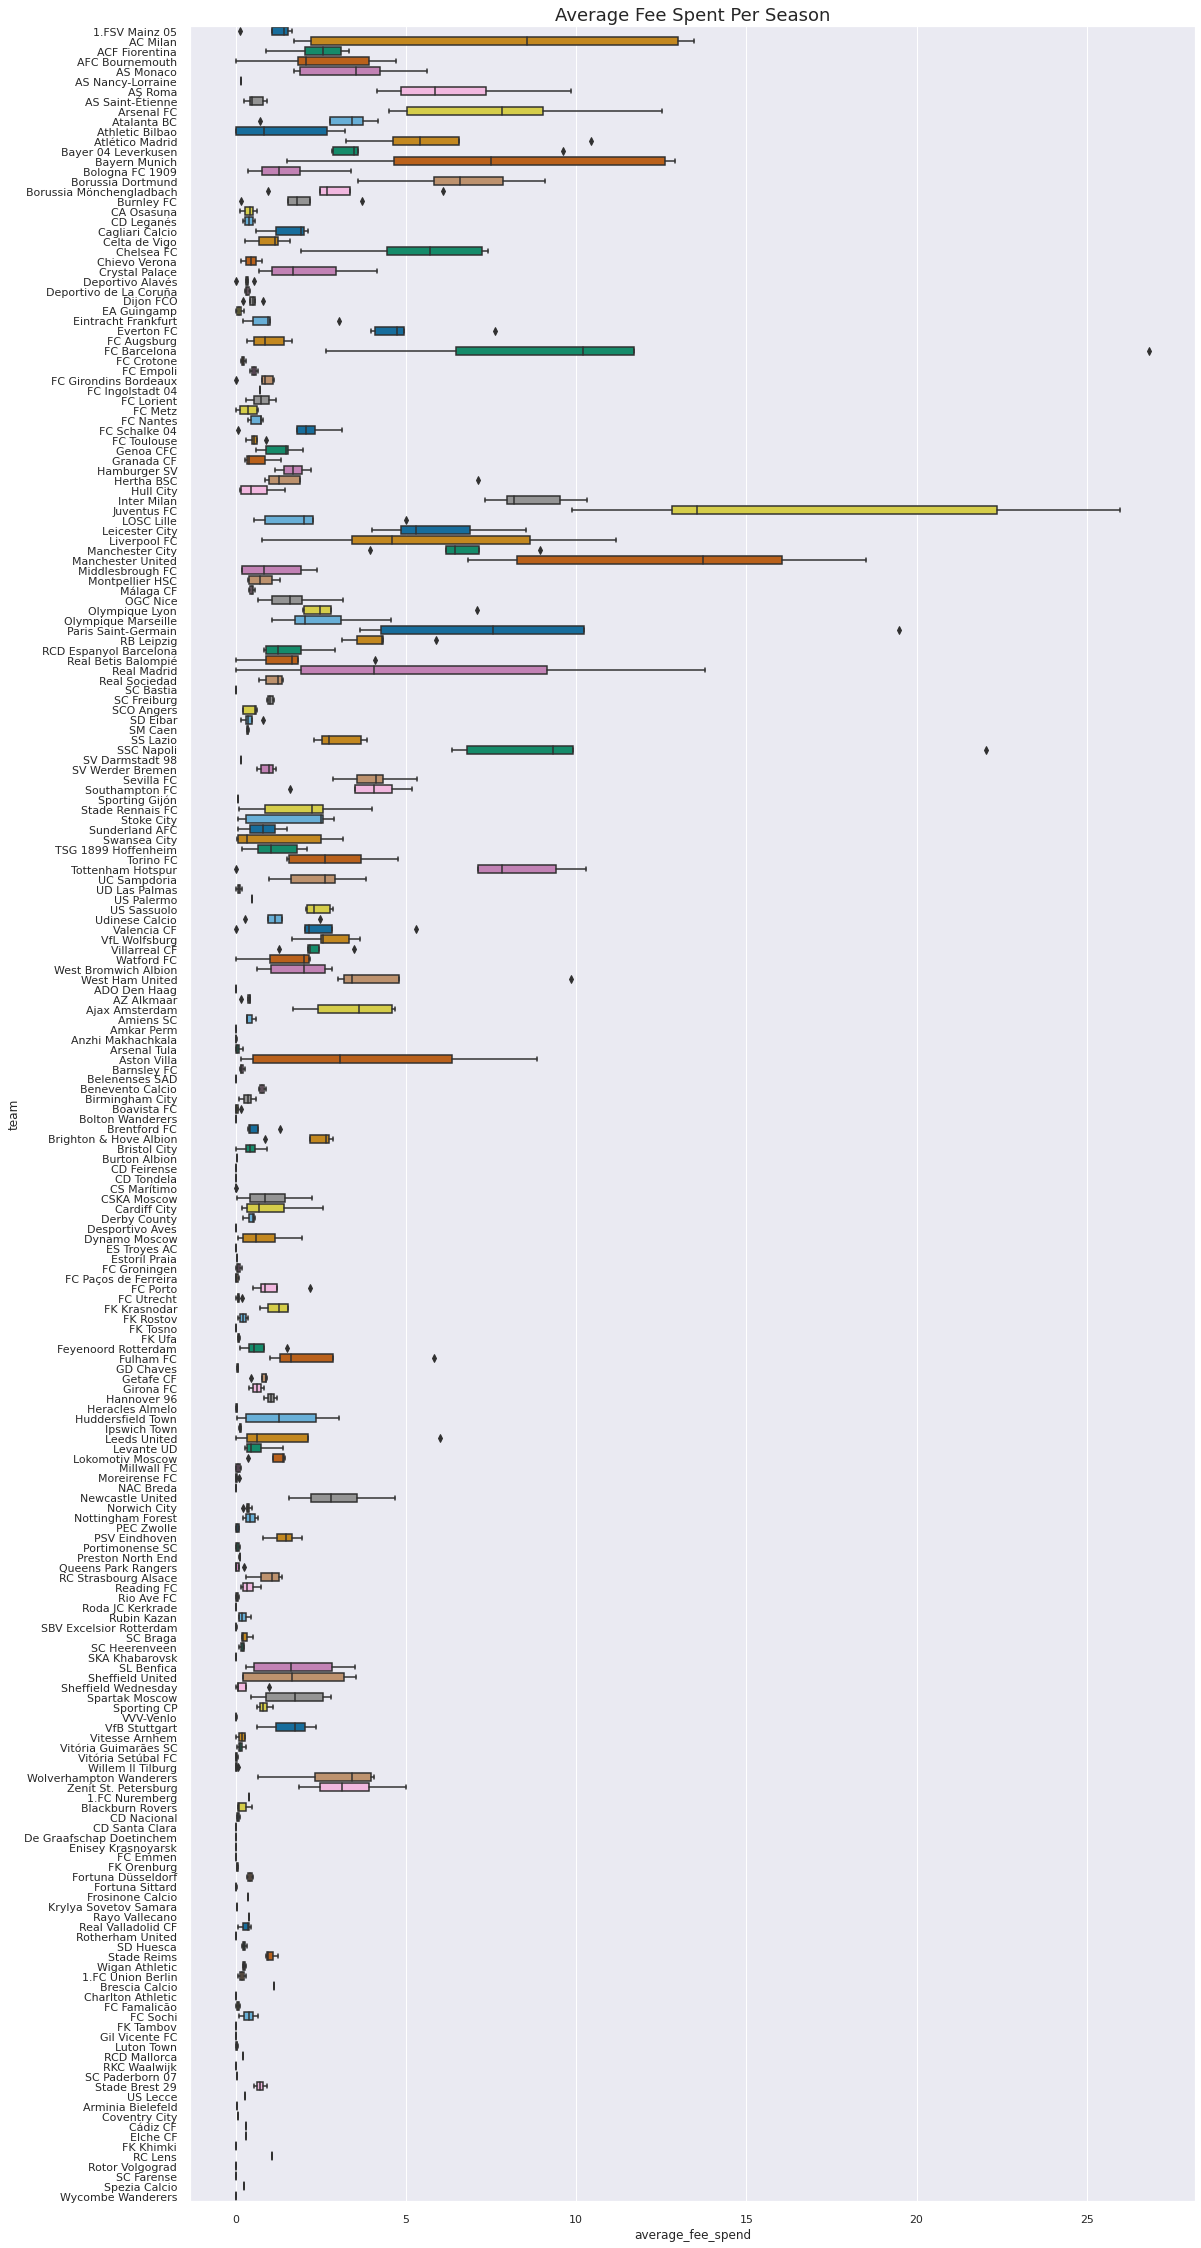

In [28]:
plt.figure(figsize=(18,40))
sns.boxplot(x='average_fee_spend', y='team', data=df, palette='colorblind')
plt.title('Average Fee Spent Per Season', fontsize=18);

#### I love swarmplots as well. I don't know why; I just think they show distributions really well, generally.
For instance, the plot below doesn't tell us much about each league, or each team. It just shows the `average_fee_spend` by year. There's at least one outlier per season, and from the boxplots above, I can get an idea of which teams might make up the outliers.

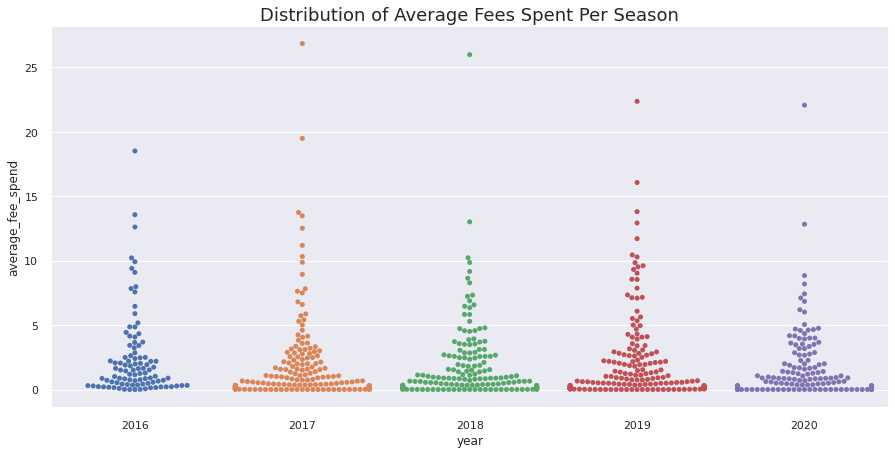

In [29]:
plt.figure(figsize=(15,7))
sns.swarmplot(x='year', y='average_fee_spend', data=df)
plt.title('Distribution of Average Fees Spent Per Season', fontsize=18);

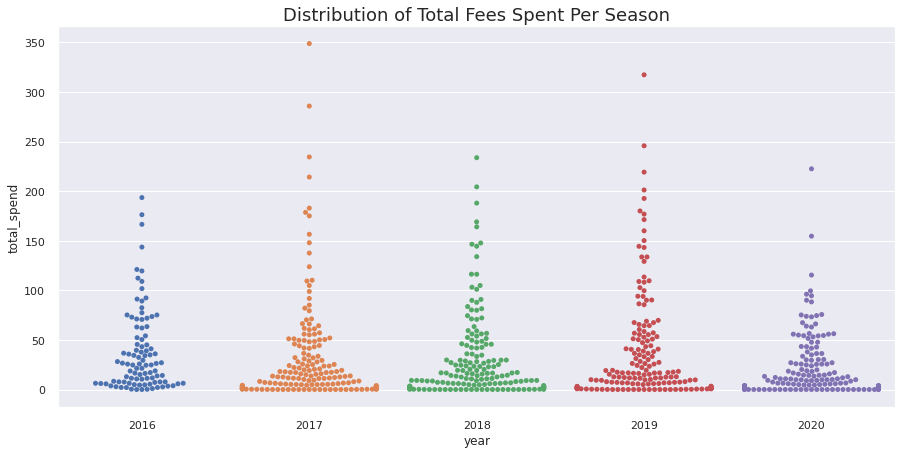

In [30]:
plt.figure(figsize=(15,7))
sns.swarmplot(x='year', y='total_spend', data=df)
plt.title('Distribution of Total Fees Spent Per Season', fontsize=18);

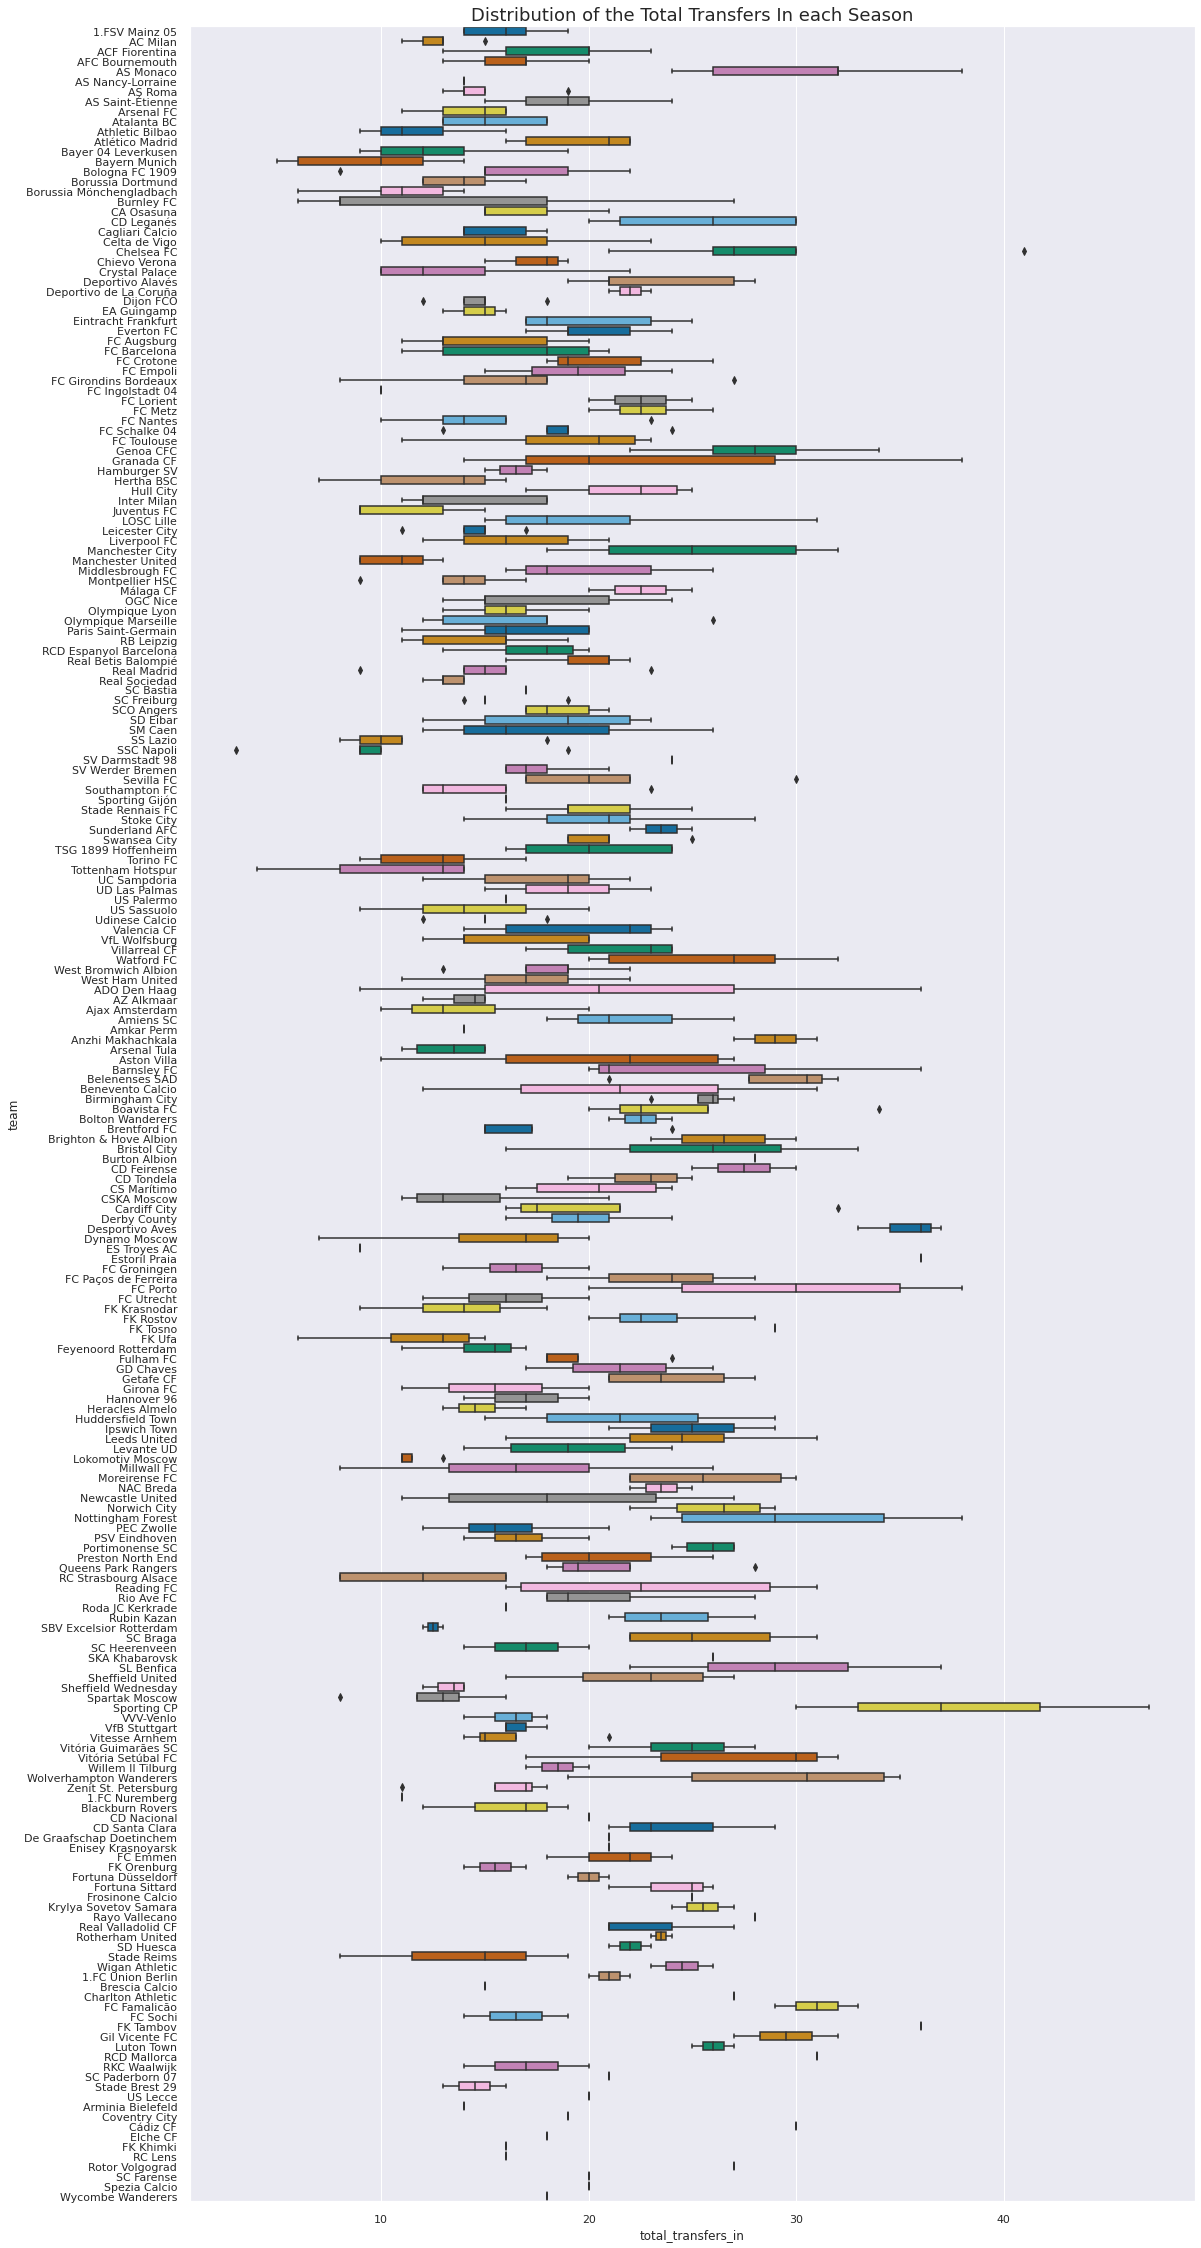

In [31]:
plt.figure(figsize=(18,40))
sns.boxplot(x='total_transfers_in', y='team', data=df, palette='colorblind')
plt.title('Distribution of the Total Transfers In each Season', fontsize=18);

#### I don't love a correlation matrix. I get why they are useful - they show how a dataset's features interact linearly in a positive or negative way.

But in my opinion, that's about all they show. From below, all I really know is that some of the columns interact really positively, e.g. `avg_season_spi`, the target variable, is positively impacted by five other features.

Fine. But next you'll see a plot of the feature importances in predicting `avg_season_spi`. This is a plot of the **Predictive Power Score**, which essentially uses evaluation metrics from a cross-validated Decision Tree to show predictive features. To learn more, see [this post on Towards Data Science](https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598).

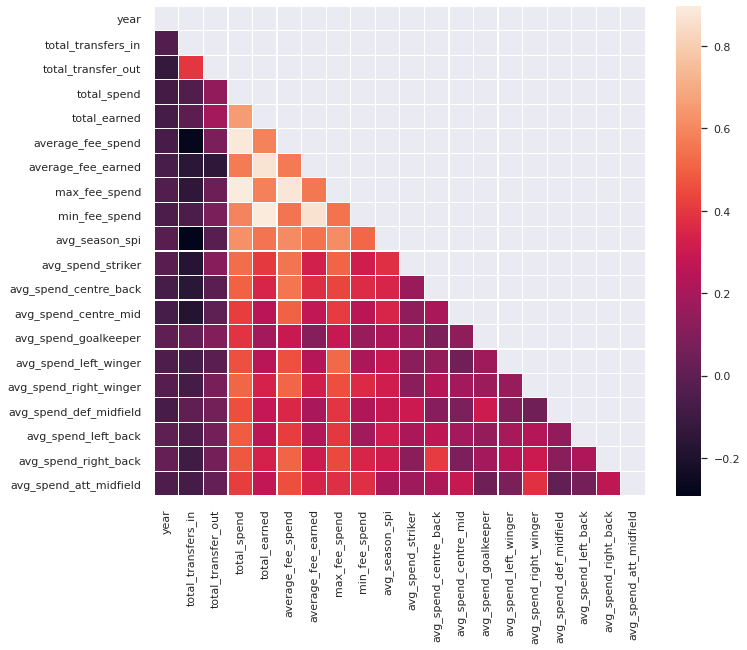

In [32]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, linewidths=.2);

Feature Importance in the prediction of avg_season_spi


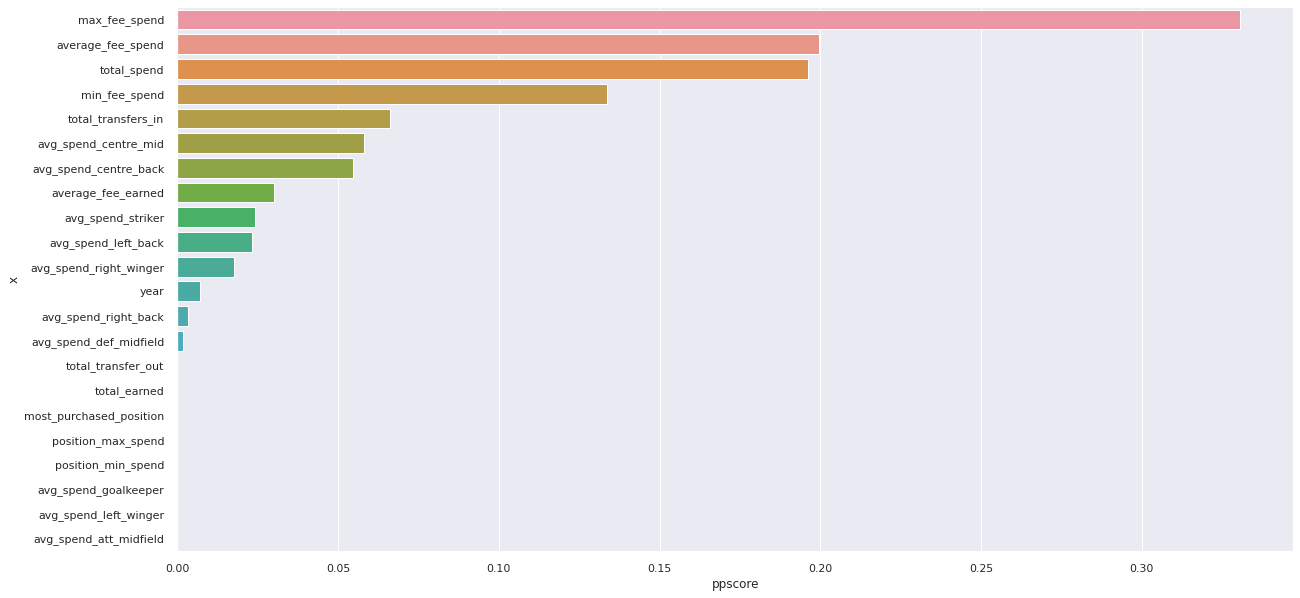

In [33]:
eda_numcat(df.drop(columns=['team', 'league']), 'avg_season_spi', method='pps')

In [34]:
eda_numcat(df, x=['year', 'league'], y=None, method='pivot')

Pivot View


average_fee_earned  average_fee_spend  \
year league                                                               
2016 English Premier League                     2.35               4.51   
     French Ligue 1                             0.96               0.92   
     German Bundesliga                          2.28               2.89   
     Italian Serie A                            0.81               2.88   
     Spanish La Liga                            1.29               1.50   
2017 Dutch Eredivisie                           0.94               0.37   
     English League Championship                0.48               0.45   
     English Premier League                     3.36               5.22   
     French Ligue 1                             1.53               2.07   
     German Bundesliga                          2.26               2.40   
     Italian Serie A                            1.03               3.78   
     Portuguese Liga                            0.52               0.14   
     Russian Premier Liga                       0.17               0.68   
     Spanish La Liga                            2.89               2.84   
2018 Dutch Eredivisie                           0.39               0.40   
     English League Championship                0.57               0.37   
     English Premier League                     1.33               4.13   
     French Ligue 1                             2.37               1.68   
     German Bundesliga                          2.23               1.84   
     Italian Serie A                            1.21               4.98   
     Portuguese Liga                            0.52               0.16   
     Russian Premier Liga                       0.62               0.50   
     Spanish La Liga                            2.34               2.41   
2019 Dutch Eredivisie                           1.31               0.38   
     English League Championship                0.74               0.43   
     English Premier League                     2.51               5.09   
     French Ligue 1                             2.46               2.00   
     German Bundesliga                          2.26               3.70   
     Italian Serie A                            1.38               4.85   
     Portuguese Liga                            0.97               0.34   
     Russian Premier Liga                       0.41               0.99   
     Spanish La Liga                            2.48               3.01   
2020 Dutch Eredivisie                           0.61               0.41   
     English League Championship                0.63               0.14   
     English Premier League                     1.25               4.07   
     French Ligue 1                             1.19               1.34   
     German Bundesliga                          1.53               1.44   
     Italian Serie A                            1.00               4.10   
     Portuguese Liga                            0.68               0.35   
     Russian Premier Liga                       0.27               0.71   
     Spanish La Liga                            1.51               0.87   

                                  avg_season_spi  avg_spend_att_midfield  \
year league                                                                
2016 English Premier League                66.05                    3.32   
     French Ligue 1                        59.51                    0.82   
     German Bundesliga                     70.18                    1.85   
     Italian Serie A                       62.19                    1.23   
     Spanish La Liga                       72.17                    1.04   
2017 Dutch Eredivisie                      41.33                    0.19   
     English League Championship           37.92                    0.34   
     English Premier League                64.68                    2.27   
     French Ligue 1                        59.52

### I think we've reached a good stopping point!

In future projects, I think I'll research the `ppscore` more closely. For now, I'm going to move on to a new stage of this project:

#### PRE-PROCESSING & MODELLING

In [35]:
df.to_csv('spi_transfers_features_created.csv')